In [104]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

## Loading the data

In [131]:
train = pd.read_csv('Tweets.csv', index_col = 'tweet_id')
train.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [106]:
train.shape

(14640, 14)

## Subsetting relevant columns for further analysis

In [107]:
train = train_raw.iloc[:, [0,4,9]]
train.head(10)

,airline_sentiment,airline,text
tweet_id,,,
570306133677760513,neutral,Virgin America,@VirginAmerica What @dhepburn said.
570301130888122368,positive,Virgin America,@VirginAmerica plus you've added commercials t...
570301083672813571,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
570301031407624196,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
570300817074462722,negative,Virgin America,@VirginAmerica and it's a really big bad thing...
570300767074181121,negative,Virgin America,@VirginAmerica seriously would pay $30 a fligh...
570300616901320704,positive,Virgin America,"@VirginAmerica yes, nearly every time I fly VX..."
570300248553349120,neutral,Virgin America,@VirginAmerica Really missed a prime opportuni...
570299953286942721,positive,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D"


## EDA to estimate sentiment type for each airline 

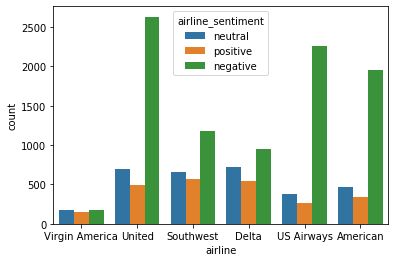

In [108]:
sns.countplot('airline', hue = 'airline_sentiment', data = train)

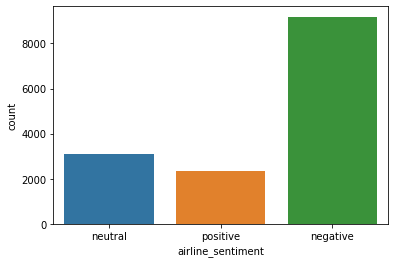

In [109]:
sns.countplot('airline_sentiment', data = train)

## Creating One-Hot encoding for airline column 

In [110]:
train = pd.get_dummies(train, columns = ['airline'])

## Converting the response in numeric format

In [111]:
train['airline_sentiment'] = train['airline_sentiment'].map({'neutral':1, 'positive':2, 'negative':0})

In [112]:
train.head(10)

,airline_sentiment,text,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
tweet_id,,,,,,,,
570306133677760513,1,@VirginAmerica What @dhepburn said.,0,0,0,0,0,1
570301130888122368,2,@VirginAmerica plus you've added commercials t...,0,0,0,0,0,1
570301083672813571,1,@VirginAmerica I didn't today... Must mean I n...,0,0,0,0,0,1
570301031407624196,0,@VirginAmerica it's really aggressive to blast...,0,0,0,0,0,1
570300817074462722,0,@VirginAmerica and it's a really big bad thing...,0,0,0,0,0,1
570300767074181121,0,@VirginAmerica seriously would pay $30 a fligh...,0,0,0,0,0,1
570300616901320704,2,"@VirginAmerica yes, nearly every time I fly VX...",0,0,0,0,0,1
570300248553349120,1,@VirginAmerica Really missed a prime opportuni...,0,0,0,0,0,1
570299953286942721,2,"@virginamerica Well, I didn't…but NOW I DO! :-D",0,0,0,0,0,1


In [113]:
X_train = train.drop(columns = 'airline_sentiment')
y_train = train['airline_sentiment']

## Creating words vectorizer of length 1 and 2  

In [114]:
word_vect = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5, 
                            stop_words='english', 
                            analyzer='word', 
                            ngram_range = (1,2), 
                            sublinear_tf = True)


word_vect.fit(X_train['text'])
X_train_word_features = word_vect.transform(X_train['text'])

In [115]:
feature_names = np.array(word_vect.get_feature_names())
print(len(word_vect.get_feature_names()))

4906


In [116]:
feature_names = np.array(word_vect.get_feature_names())
print('Some elements of feature names in word vectorizer are:\n{}\n'.format(feature_names[::200]))

Some elements of feature names in word vectorizer are:
['00' '9am' 'americanair really' 'bag amp' 'car seat' 'confusion'
 'department' 'emailed' 'flight' 'flying southwest' 'grr' 'hours help'
 'jetblue plane' 'line' 'messaged' 'oakland' 'plane hours' 'redcarpet'
 'seat flight' 'southwestair fly' 'svc' 'training' 'united love'
 'usairways stuck' 'whats']



## Creating character vectorizer of length 3 to 6

In [117]:
char_vect = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5, 
                            stop_words='english', 
                            analyzer='char', 
                            ngram_range = (3,6), 
                            sublinear_tf = True, 
                            max_features = 10000)


char_vect.fit(X_train['text'])
X_train_char_features = char_vect.transform(X_train['text'])

In [118]:
## Stacking for the arrays together
X_train_final = hstack([X_train_word_features, X_train_char_features, X_train.drop(columns = 'text')])

## Logistic Model

In [119]:
model_logistic = LogisticRegression(C = 0.1, multi_class = 'multinomial', solver = 'lbfgs')
cv_score = np.mean(cross_val_score(model_logistic, X_train_final, y_train, cv=10, scoring='accuracy'))
print(cv_score)

0.72963816718191


## Naive Bayes Model

In [120]:
model_NB = MultinomialNB()
cv_score = np.mean(cross_val_score(model_NB, X_train_final, y_train, cv=10, scoring='accuracy'))
print(cv_score)

0.7366074494755378


## Random Forest Model

In [121]:
model_random_forest = RandomForestClassifier(n_estimators=500, min_samples_leaf = 5)
model_random_forest.fit(X_train_final, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [122]:
model_random_forest.score(X_train_final, y_train)

0.8378415300546448

## Words with highest and lowest coefficient value 

In [123]:
model_logistic = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
model_logistic.fit(X_train_word_features, y_train)
sorted_coef_index = model_logistic.coef_[0].argsort()
print('Words with Smallest Coefs values are :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Words with Largest Coefs values are : \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Words with Smallest Coefs values are :
['thank' 'thanks' 'virginamerica' 'jetblue' 'southwestair' 'love'
 'awesome' 'great' 'amazing' 'kudos']

Words with Largest Coefs values are : 
['hours' 'worst' 'hold' 'delayed' 'hour' 'delay' 'luggage' 'hrs' 'fail'
 'stuck']



C:\Users\singh\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Words with highest and lowest tfidf value 

In [124]:
sorted_tfidf_index = X_train_word_features.max(0).toarray()[0].argsort()
print('Words with smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Words with largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Words with smallest tfidf:
['cessna 747' 'folks cessna' 'airport snow' 'cessna' 'removal method'
 'method 22' 'snow removal' 'removal' '22 good' 'work folks']

Words with largest tfidf: 
['americanair' 'virginamerica' 'jetblue' 'united' 'southwestair'
 'usairways' 'rude' 'https' '25' 'aisle']


## Deep Learning Model (through Keras)

In [125]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold

In [126]:
vocab_size = 100000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [127]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train['text'])
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [128]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 120, 16)           1600000   
_________________________________________________________________
flatten_21 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 6)                 11526     
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 21        
Total params: 1,611,547
Trainable params: 1,611,547
Non-trainable params: 0
_________________________________________________________________


In [129]:
labels = np.array(y_train)

In [130]:
num_epochs = 5
model.fit(padded, labels, epochs=num_epochs)

Epoch 1/5
14640/14640 [==============================] - 17s 1ms/sample - loss: 0.7649 - accuracy: 0.6557
Epoch 2/5
14640/14640 [==============================] - 15s 1ms/sample - loss: 0.5714 - accuracy: 0.7374
Epoch 3/5
14640/14640 [==============================] - 16s 1ms/sample - loss: 0.4601 - accuracy: 0.8102
Epoch 4/5
14640/14640 [==============================] - 17s 1ms/sample - loss: 0.3298 - accuracy: 0.9036
Epoch 5/5
14640/14640 [==============================] - 16s 1ms/sample - loss: 0.2061 - accuracy: 0.9436
